# Explore different explanation wrappers
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/understandable-machine-intelligence-lab/Quantus/main?labpath=tutorials%2FTutorial_Explore_Explanation_Wrappers.ipynb)


This notebook shows how to use the wrappers around different explanation libraries built into Quantus.  

For this purpose, we use a pre-trained ResNet-18 model and ImageNet dataset. A description for how to download the dataset can be found here: https://image-net.org/download.php.

- Make sure to have GPUs enabled to speed up computation.


## 1) Preliminaries

In [ ]:
from IPython.display import clear_output
!pip install torch torchvision captum quantus zennit
clear_output()

In [ ]:
import sys
import os
import cv2
import json
import random
from PIL import Image
import pathlib
import numpy as np
import pandas as pd
import quantus
import torch
import torchvision
from captum.attr import *
import matplotlib.pyplot as plt
import seaborn as sns
import zennit
sns.set()

# Enable GPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
clear_output()

### 1.1 Load datasets

We have prepared a small subset of ImageNet images which can be downloaded at: <https://github.com/understandable-machine-intelligence-lab/Quantus/tree/main/tutorials/assets/imagenet_samples/>. Please make sure to download the contents of the folder, that are, the inputs `x_batch.pt`, outputs `y_batch.pt` and segmentation masks `s_batch.pt`. (A description for how to download the full dataset can be found here: <https://image-net.org/download.php>.)

If you use Google Colab, you might want to add the following:

```python
# Mount Google Drive.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
````

In [ ]:
# Adjust this path.
path_to_files = "drive/MyDrive/Projects/quantus/tutorials/assets/imagenet_samples"

# Load test data and make loaders.
x_batch = torch.load(f'{path_to_files}/x_batch.pt')
y_batch = torch.load(f'{path_to_files}/y_batch.pt')
s_batch = torch.load(f'{path_to_files}/s_batch.pt')
x_batch, s_batch, y_batch = x_batch.to(device), s_batch.to(device), y_batch.to(device)
print(f"{len(x_batch)} matches found.")

17 matches found.


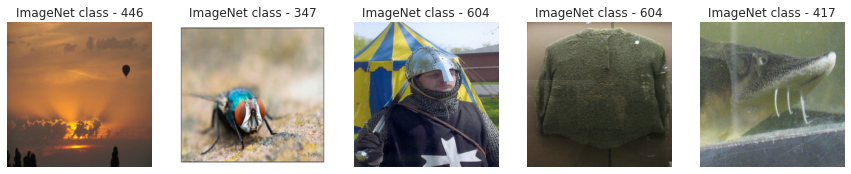

In [ ]:
# Plot some inputs!

nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow((np.moveaxis(quantus.normalise_func.denormalise(x_batch[i].cpu().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1) * 255).astype(np.uint8), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class - {y_batch[i].item()}")
    axes[i].axis("off")
plt.show()

### 1.2 Load a pre-trained model

In this example we load a pre-trained ResNet-18 model but it goes without saying that any model works.

In [ ]:
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

## 2) Use different wrappers to generate attribution-based explanations

While quantus accepts pre-computed explanations, several wrappers around existing XAI libraries are also provided. 
How to use the wrapped libraries will be showcased below.
Quantus detects installed explanation libraries automatically, and uses the appropriate wrappers. However, if multiple ones are installed, for pytorch, the default is to use *captum*.


### 2.1 Captum

Define the XAI method that should be used to generate explanations. For the `captum` wrapper, this is a string. For example, the parameters for generating Integrated Gradient explanations look like the following.


In [ ]:
# String defining the XAI method.
method = "IntegratedGradients" 

In [ ]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(
    model, 
    x_batch, 
    y_batch, 
    method=method,
)

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch_tmp, y_batch_tmp = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch_tmp, y_batch_tmp, a_batch]]

Visualize attributions given model and pairs of input-output.

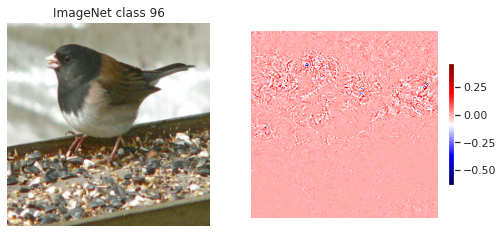

In [ ]:
index = random.randint(0, len(x_batch)-1)

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch_tmp[index], mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"ImageNet class {y_batch_tmp[index].item()}")
exp = axes[1].imshow(a_batch[index].reshape(224, 224), cmap="seismic") 
fig.colorbar(exp, fraction=0.03, pad=0.05); 
axes[0].axis("off"); axes[1].axis("off"); plt.show();

### 2.2. Zennit

Define the XAI method that should be used to generate explanations. For the `zennit` wrapper, this is defined through a triple of canonizer, composite, and attributor. For example, the parameters for generating Integrated Gradient explanations look like the following.

In [ ]:
# The canonizer can be a zennit.canonizers.Canonizer subclass or None.
canonizer = None 

# The composite can be a zennit.core.Composite subclass, a string mapping to a composite, or None.
composite = None

# The attributor can be any zennit.attribution.Attributor subclass.
attributor = zennit.attribution.IntegratedGradients 

# In case both captum and zennit are installed, this kwarg also needs to be set to "zennit"
xai_lib = "zennit"

In [ ]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(
    model, 
    x_batch, 
    y_batch, 
    canonizer=canonizer,
    composite=composite,
    attributor=attributor,
)

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch_tmp, y_batch_tmp = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch]]

/usr/local/lib/python3.7/dist-packages/quantus/helpers/explanation_func.py:49: UserWarning: Using quantus 'explain' function as an explainer without specifying 'method' (str) in kwargs will produce a vanilla 'Gradient' explanation.

  category=UserWarning,
/usr/local/lib/python3.7/dist-packages/captum/_utils/gradient.py:59: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


Visualize attributions given model and paris of input-output.

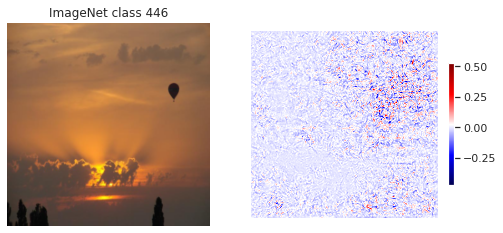

In [ ]:
index = random.randint(0, len(x_batch)-1)

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch_tmp[index], mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"ImageNet class {y_batch_tmp[index].item()}")
exp = axes[1].imshow(a_batch[index].reshape(224, 224), cmap="seismic") 
fig.colorbar(exp, fraction=0.03, pad=0.05); 
axes[0].axis("off"); axes[1].axis("off"); plt.show();